# Import packages

In [62]:
# loading packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
plt.rcParams['figure.dpi'] = 300

import matplotlib.dates as mdates

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

In [63]:
import sklearn as sk
import statsmodels.api as sm

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import ARMA
import statsmodels.api as sm


from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
# from statsmodels.tsa.vector_ar.var_model import VAR

from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

import copy

# Custom functions

In [3]:
def diff_for_stationarity(df_input,cols,threshold):
    
    """Checks the series for stationarity then difference it until it is stationary
    (with the given threshold)"""
    
    df = copy.deepcopy(df_input)
    
    
    # Get length of DF
    n = len(df)
    
    # Loop over columns of interest
    for col in cols:
        stationarity = False
        series = list(df[col].astype(float))
        linear_diff = False
        
        try:
        
            counter = 0



            while not stationarity:

                #print(counter)

                # Run ADF test
                adf_test = adfuller(series)
                pval = adf_test[1]

                if pval < threshold:
                    stationarity = True

                else:
                    # Difference the series
                    series = [np.log(series[i]/series[i-1]) for i in range(1,n-counter)]
                    #series = [series[i]-series[i-1] for i in range(1,n-counter)]

                    counter += 1
                    
        except:
            
            counter = 0
            stationarity = False
            series = list(df[col].astype(float))
            linear_diff = True

            while not stationarity:

                #print(counter)

                # Run ADF test
                adf_test = adfuller(series)
                pval = adf_test[1]

                if pval < threshold:
                    stationarity = True

                elif counter>1:
                    stationarity = True
                    series = list(df[col].astype(float))
                else:
                    # Difference the series
                    series = [series[i]-series[i-1] for i in range(1,n-counter)]

                    counter += 1
        
        # Create final series and assign it back to the dataframe
        final_series = [None]*counter + series
        df[col] = final_series
        
        if linear_diff:
            type_diff = "log difference"
        else:
            type_diff = "linear difference"
        
        print("Variable: {} is {}-order integrated ({})!".format(col,counter,type_diff))
        
        
    return df

# Import data

In [4]:
df = pd.read_csv('../Data/merged_dataset.csv')

df.set_index('Date',inplace=True)

print(df.head())

            carbon_price  oil_price  gas_price  stock_market_index_level  \
Date                                                                       
2017-01-02          6.12      56.82        NaN                    363.18   
2017-01-03          5.43      55.47      49.45                    365.71   
2017-01-04          5.72      56.46      50.68                    365.26   
2017-01-05          5.29      56.89      50.69                    365.64   
2017-01-06          5.50      57.10      49.77                    365.45   

            energy_price  coal_price  
Date                                  
2017-01-02           NaN         NaN  
2017-01-03           NaN       82.50  
2017-01-04           NaN       84.20  
2017-01-05           NaN       85.75  
2017-01-06           NaN       84.75  


# EDA

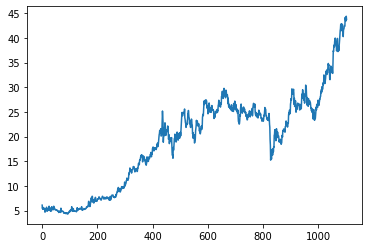

In [6]:
plt.plot(np.asarray(df.carbon_price))
plt.show()

# Data preprocessing

## Handle missing values

In [7]:
df = df.fillna(method='bfill')

## Stationarity checks

In [8]:
# Parameters
stacioner_threshold = 0.01
arno_cols = df.columns
current_df = df

# Check for stationarity
df_stationer = diff_for_stationarity(df_input=current_df,cols=arno_cols,threshold=stacioner_threshold)

Variable: carbon_price is 1-order integrated (linear difference)!
Variable: oil_price is 1-order integrated (linear difference)!
Variable: gas_price is 1-order integrated (linear difference)!
Variable: stock_market_index_level is 1-order integrated (linear difference)!
Variable: energy_price is 1-order integrated (linear difference)!
Variable: coal_price is 1-order integrated (linear difference)!


In [9]:
df_stationer

,carbon_price,oil_price,gas_price,stock_market_index_level,energy_price,coal_price
Date,,,,,,
2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,-0.119623,-0.024046,0.000000,0.006942,0.000000,0.000000
2017-01-04,0.052030,0.017690,0.024569,-0.001231,0.000000,0.020397
2017-01-05,-0.078151,0.007587,0.000197,0.001040,0.000000,0.018241
2017-01-06,0.038930,0.003685,-0.018316,-0.000520,0.000000,-0.011730
...,...,...,...,...,...,...
2021-04-07,-0.008646,0.006672,-0.020841,-0.002162,-0.017229,-0.021568
2021-04-08,-0.008722,0.000633,-0.015973,0.005831,0.015196,-0.023530
2021-04-09,0.004141,-0.003964,-0.007229,0.000847,-0.001271,0.005195


In [10]:
# Drop first row after differencing the series
df_stationer = df_stationer.dropna()

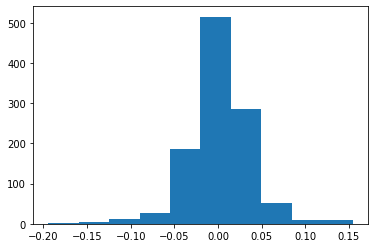

In [11]:
plt.hist(df_stationer.carbon_price)
plt.show()

# Modelling

In [12]:
# Create train-test sets
n = len(df_stationer)
testsize = 0.2

test_obs = int(n*testsize)
df_train, df_test = df_stationer[0:-test_obs], df_stationer[-test_obs:]

# Check size
print(df_train.shape)
print(df_test.shape)

# Be careful with time leakage!

(883, 6)
(220, 6)


## ARMA(p,q)

In [12]:
# Fit the model
res = sm.tsa.arma_order_select_ic(df_train['Price'], ic=["aic", "bic","hqic"], trend="nc")

In [13]:
print(res)

{'aic':              0            1            2
0          NaN  1520.552218  1522.184938
1  1520.528546  1520.305567  1521.739969
2  1522.060128  1521.818077  1520.336887
3  1520.890512  1521.980282  1520.040755
4  1522.380827  1523.859906  1521.799772, 'bic':              0            1            2
0          NaN  1530.118868  1536.534913
1  1530.095196  1534.655543  1540.873270
2  1536.410104  1540.951377  1544.253513
3  1540.023813  1545.896908  1548.740706
4  1546.297453  1552.559857  1555.283048, 'hqic':              0            1            2
0          NaN  1524.210087  1527.671742
1  1524.186416  1525.792371  1529.055709
2  1527.546933  1529.133816  1529.481561
3  1528.206251  1531.124956  1531.014364
4  1531.525502  1534.833515  1534.602316, 'aic_min_order': (3, 2), 'bic_min_order': (1, 0), 'hqic_min_order': (1, 0)}


In [14]:
# Parameters
order = (1,0)

# Initialise model
arma_model = ARMA(df_train['Price'],order)

In [15]:
# Fit the model with the selected order
arma_model_fitted = arma_model.fit()
arma_model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                  883
Model:                     ARMA(1, 0)   Log Likelihood                -757.794
Method:                       css-mle   S.D. of innovations              0.571
Date:                Sun, 18 Apr 2021   AIC                           1521.588
Time:                        15:13:46   BIC                           1535.938
Sample:                             0   HQIC                          1527.075
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0182      0.019      0.970      0.332      -0.019       0.055
ar.L1.Price    -0.0264      0.034     -0.783      0.434      -0.092       0.040
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -37.9460           +0.0000j           37.9460            0.5000
-----------------------------------------------------------------------------
"""

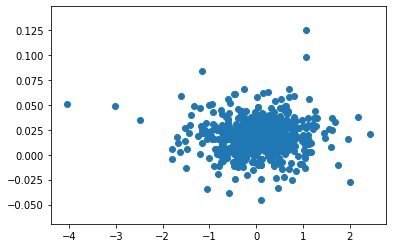

In [16]:
# Compare prediction and actual
arma_y_pred = arma_model.predict(params = arma_model_fitted.params)
y_true = df_train['Price']

plt.scatter(y_true,arma_y_pred)
plt.show()

In [25]:
arma_model_fitted.params[1]

-0.026353209455527115

In [29]:
df_test['Price'].values[1]

-0.5200000000000031

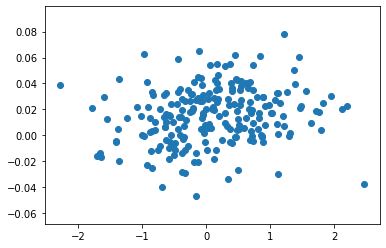

In [31]:
# Compare prediction and actual
arma_y_pred_test = []
for i in range(0,len(df_test)):
    if i == 0:
        pred = arma_model_fitted.params[1]*df_train['Price'].values[-1] + arma_model_fitted.params[0]
    else:
        pred = arma_model_fitted.params[1]*df_test['Price'].values[i-1] + arma_model_fitted.params[0]
        
    arma_y_pred_test.append(pred)

#arma_y_pred_test = arma_model_fitted.forecast(steps=len(df_test))
y_test = df_test['Price']

plt.scatter(y_test,arma_y_pred_test)
plt.show()

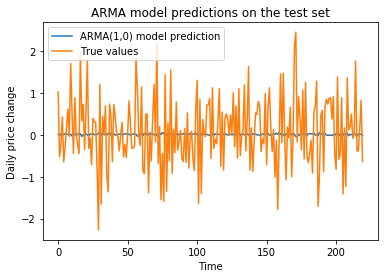

In [33]:
# Compare prediction and actual in the test set
plt.plot(np.asarray(arma_y_pred_test),label='ARMA(1,0) model prediction')
plt.plot(np.asarray(y_test),label='True values')
plt.xlabel('Time')
plt.ylabel('Daily price change')
#plt.yscale('log')
plt.title('ARMA model predictions on the test set')
plt.legend(loc='upper left')
plt.savefig('../Outputs/daily_pred_arma.pdf')
plt.show()

In [32]:
mean_squared_error(arma_y_pred_test,y_test)

0.6770827066931189

## Random forest

In [18]:
rf_model = RandomForestRegressor(max_depth=5, n_estimators=30, random_state=0)

In [19]:
X_train = df_train.shift(1).iloc[1:,:].values

y_train = df_train['Price'].iloc[1:]

X_test = df_test.shift(1).iloc[1:,:].values

y_test = df_test['Price'].iloc[1:]

In [20]:
# Fit the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [21]:
# Predict with the model
rf_y_pred = rf_model.predict(X_test)

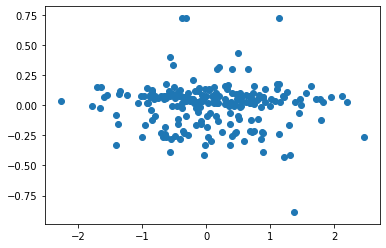

In [22]:
# Compare prediction and actual in the test set
plt.scatter(y_test,rf_y_pred)
plt.show()

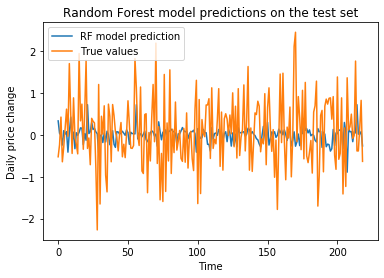

In [25]:
# Compare prediction and actual in the test set
plt.plot(np.asarray(rf_y_pred),label='RF model prediction')
plt.plot(np.asarray(y_test),label='True values')
plt.xlabel('Time')
plt.ylabel('Daily price change')
#plt.yscale('log')
plt.title('Random Forest model predictions on the test set')
plt.legend(loc='upper left')
plt.savefig('../Outputs/daily_pred_rf.pdf')
plt.show()

In [26]:
mean_squared_error(rf_y_pred,y_test)

0.7358365156955068

## Granger causility

In [20]:
 gc_res = grangercausalitytests(df_stationer[[ 'carbon_price', 'oil_price']], 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2795  , p=0.5971  , df_denom=1099, df_num=1
ssr based chi2 test:   chi2=0.2803  , p=0.5965  , df=1
likelihood ratio test: chi2=0.2802  , p=0.5966  , df=1
parameter F test:         F=0.2795  , p=0.5971  , df_denom=1099, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5811  , p=0.2062  , df_denom=1096, df_num=2
ssr based chi2 test:   chi2=3.1766  , p=0.2043  , df=2
likelihood ratio test: chi2=3.1721  , p=0.2047  , df=2
parameter F test:         F=1.5811  , p=0.2062  , df_denom=1096, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.5688  , p=0.0035  , df_denom=1093, df_num=3
ssr based chi2 test:   chi2=13.7942 , p=0.0032  , df=3
likelihood ratio test: chi2=13.7084 , p=0.0033  , df=3
parameter F test:         F=4.5688  , p=0.0035  , df_denom=1093, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.9953  , p=0.

In [33]:
# Simple OLS regression
mod = sm.OLS( df_stationer[ 'carbon_price'], df_stationer[ [ 'oil_price', 'gas_price', 'stock_market_index_level',
       'energy_price', 'coal_price'] ] )

res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:           carbon_price   R-squared (uncentered):                   0.130
Model:                            OLS   Adj. R-squared (uncentered):              0.126
Method:                 Least Squares   F-statistic:                              32.84
Date:                Thu, 15 Jul 2021   Prob (F-statistic):                    2.77e-31
Time:                        19:29:22   Log-Likelihood:                          2185.9
No. Observations:                1103   AIC:                                     -4362.
Df Residuals:                    1098   BIC:                                     -4337.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [51]:
# Regression with lagged values

X = pd.DataFrame( index = df_stationer.index )
lag = 1
for col in df_stationer.columns:
    variable_name = col + '_lag'
    X[ variable_name ] = df_stationer[ col ].shift( lag ) 

X = sm.add_constant(X)
print( X.tail() )
y = df_stationer.loc[ :, 'carbon_price' ]


model = sm.OLS( y, X, missing='drop' )
result = model.fit()
print( result.summary() )

            const  carbon_price_lag  oil_price_lag  gas_price_lag  \
Date                                                                
2021-04-07    1.0          0.040926       0.009448       0.000000   
2021-04-08    1.0         -0.008646       0.006672      -0.020841   
2021-04-09    1.0         -0.008722       0.000633      -0.015973   
2021-04-12    1.0          0.004141      -0.003964      -0.007229   
2021-04-13    1.0          0.018875       0.005229       0.047509   

            stock_market_index_level_lag  energy_price_lag  coal_price_lag  
Date                                                                        
2021-04-07                      0.000000          0.000000        0.001423  
2021-04-08                     -0.002162         -0.017229       -0.021568  
2021-04-09                      0.005831          0.015196       -0.023530  
2021-04-12                      0.000847         -0.001271        0.005195  
2021-04-13                     -0.004562         -0.02

In [98]:
# Rolling OLS
def RollingOLS( data, y, X, window ):
    results = {}
    pvalues = pd.DataFrame( columns = X.columns, index = data.index[ window:data.shape[ 0 ] ] )
    coefs = pd.DataFrame( columns = X.columns, index = data.index[ window:data.shape[ 0 ] ] )

    for end_date in range( window, data.shape[ 0 ] ):
        start_date = end_date - window + 1
        model = sm.OLS( y.iloc[ start_date:end_date ], X.iloc[ start_date:end_date, : ], missing='drop' )
        result = model.fit()
        # print( result.summary() )
        results[ data.index[ end_date ] ] = result  
        pvalues.iloc[ start_date - 1, : ] = result.pvalues
        coefs.iloc[ start_date - 1, : ] = result.params

    return results, pvalues, coefs

results, pvalues, coefs = RollingOLS( df_stationer, y, X, 200 )
print( pvalues )

                const carbon_price_lag oil_price_lag gas_price_lag  \
Date                                                                 
2017-10-11   0.529393      2.55868e-06      0.507468      0.195302   
2017-10-12   0.517735      4.54232e-06       0.54034      0.211775   
2017-10-13   0.464421      5.03716e-06      0.591482      0.194369   
2017-10-16   0.491791      7.88014e-06      0.584934      0.191139   
2017-10-17   0.459225      1.04215e-05      0.594298      0.207368   
...               ...              ...           ...           ...   
2021-04-07  0.0437416        0.0951394      0.265661      0.145117   
2021-04-08  0.0636865         0.114613      0.245171      0.113437   
2021-04-09  0.0751349        0.0841128      0.223531      0.102812   
2021-04-12   0.088794        0.0792639      0.246906     0.0988629   
2021-04-13  0.0759112        0.0892397      0.253464     0.0888513   

           stock_market_index_level_lag energy_price_lag coal_price_lag  
Date           

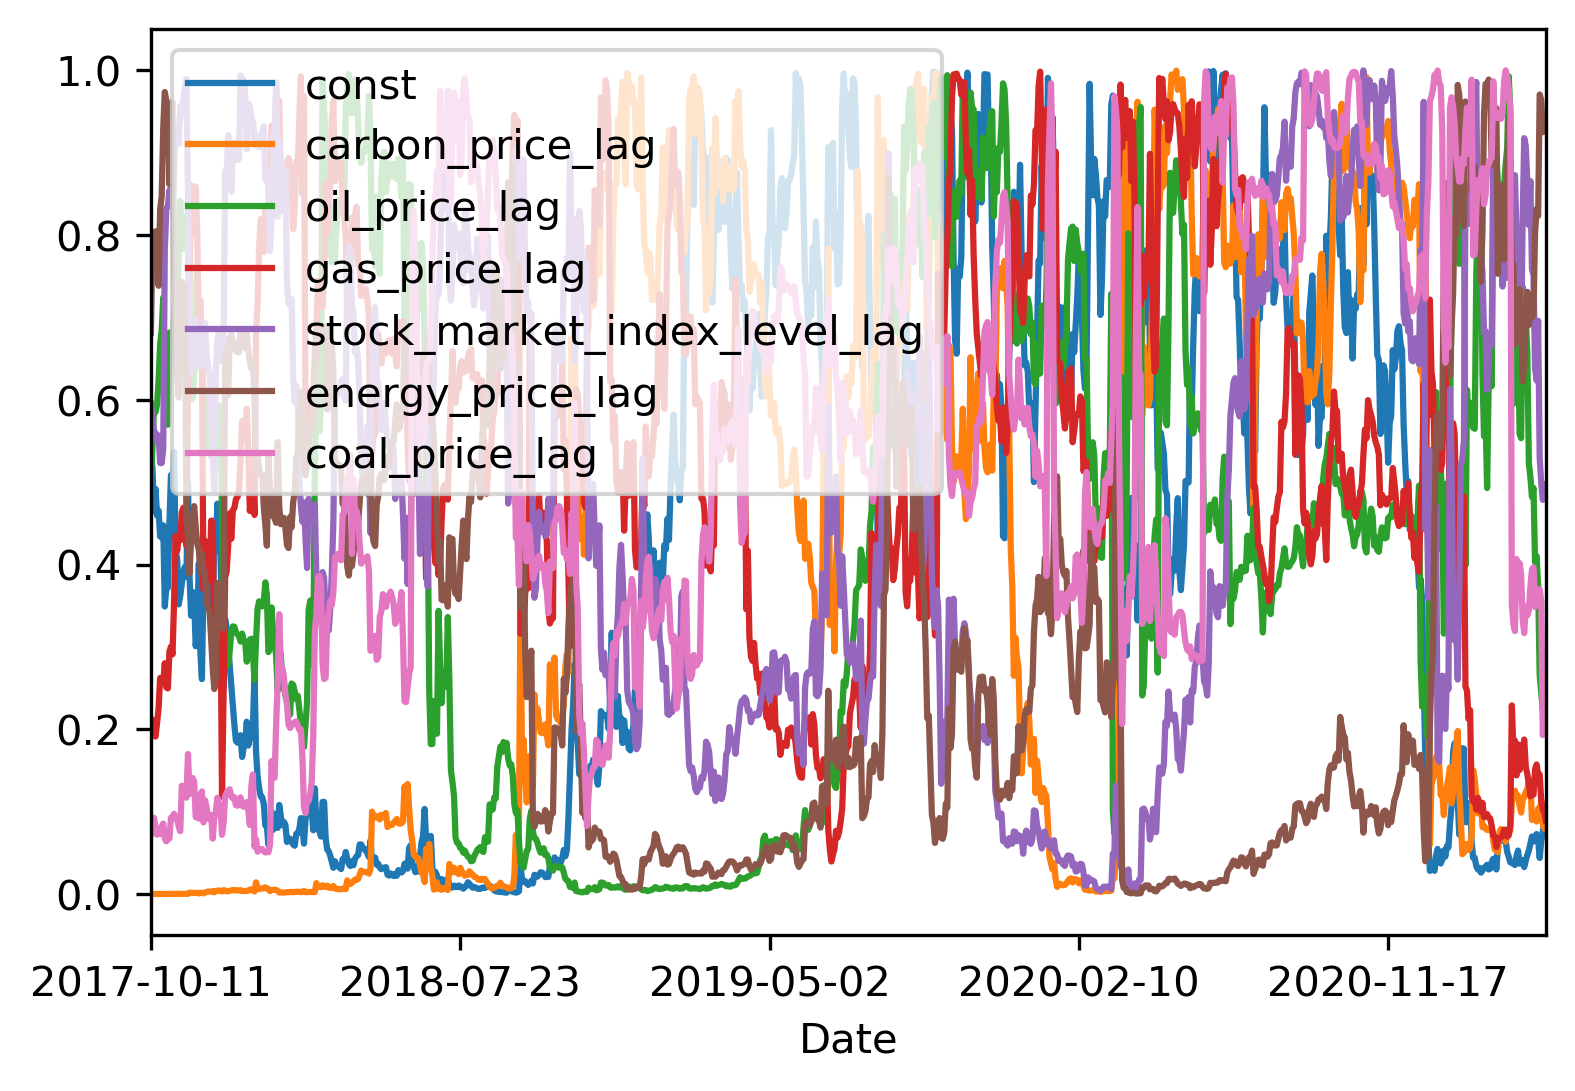

In [99]:
# Plot p values
pvalues.plot.line()